<a href="https://colab.research.google.com/github/GymYJ/RNN_time-series/blob/master/rnn_smp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [62]:
%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import os

tf.set_random_seed(777)  # reproducibility

def MinMaxScaler(data):
    ''' Min Max Normalization
    Parameters
    ----------
    data : numpy.ndarray
        input data to be normalized
        shape: [Batch size, dimension]
    Returns
    ----------
    data : numpy.ndarry
        normalized data
        shape: [Batch size, dimension]
    References
    ----------
    .. [1] http://sebastianraschka.com/Articles/2014_about_feature_scaling.html
    '''
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    # noise term prevents the zero division
    return numerator / (denominator + 1e-7)


# train Parameters
seq_length = 30
data_dim = 24
hidden_dim = 10
output_dim = 24
learning_rate = 0.01
iterations = 2500

# Open, Close
f = open('/content/gdrive/My Drive/Colab Notebooks/smp_land_2019.csv', 'rt', encoding='UTF8')
for i in range(4): f.readline() # 설명, 인덱스 부분 날리기
lines = f.readlines()
data = []
for line in lines:
    data.append(line.strip('\n').split(',')[1:-3])
data = np.array(data).astype(np.float)
xy = data[::-1]  # reverse order (chronically ordered)

# train/test split
train_size = int(len(xy) * 0.7)
train_set = xy[0:train_size]
test_set = xy[train_size - seq_length:]  # Index from [train_size - seq_length] to utilize past sequence

print(len(xy))
print(len(train_set))
print(len(test_set))
train_set.shape

361
252
139


(252, 24)

In [24]:
print(train_set[0:7,:])
print(train_set[7,[-1]])

[[0.54434907 0.54343629 0.53502747 0.6073764  0.54794842 0.53428113
  0.59479905 0.67075472 0.65709765 0.66400178 0.66168389 0.66563124
  0.62443546 0.64518287 0.62089752 0.61621004 0.30205349 0.55947813
  0.41220799 0.14764849 0.20207702 0.18432971 0.49490835 0.52277904]
 [0.51478302 0.52799228 0.52037546 0.59351295 0.56131301 0.54735152
  0.55791962 0.65023585 0.64918626 0.65711748 0.66234337 0.66429998
  0.67078678 0.66636931 0.64210761 0.63127854 0.3008596  0.56792018
  0.40015071 0.14165261 0.20337516 0.19746377 0.5053826  0.51594533]
 [0.57510729 0.60352316 0.58951465 0.59063562 0.52825322 0.5507911
  0.56122931 0.5379717  0.51785714 0.52631579 0.53132556 0.53450188
  0.55146185 0.51940232 0.5114981  0.48082192 0.23101719 0.45203377
  0.25621703 0.07101368 0.11639983 0.11503623 0.45912133 0.47067198]
 [0.56175489 0.55719112 0.54807692 0.60868428 0.54677608 0.5331346
  0.58817967 0.65400943 0.66161844 0.66422385 0.64102    0.64544042
  0.62348467 0.62689563 0.6260326  0.61484018 0

In [63]:

# Scale each
train_set = MinMaxScaler(train_set)
test_set = MinMaxScaler(test_set)

# build datasets
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series) - seq_length):
        _x = time_series[i:i + seq_length, :]
        _y = time_series[i + seq_length, :]  # Next close price
        #print(_x, "->", _y)
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

trainX, trainY = build_dataset(train_set, seq_length)
testX, testY = build_dataset(test_set, seq_length)

print("build datasets done")


build datasets done


In [64]:
tf.reset_default_graph()
# input place holders
X = tf.placeholder(tf.float32, [None, seq_length, data_dim])
Y = tf.placeholder(tf.float32, [None, 24])

# build a LSTM network
cell = tf.contrib.rnn.BasicLSTMCell(
    num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
Y_pred = tf.contrib.layers.fully_connected(
    outputs[:, -1], output_dim, activation_fn=None)  # We use the last cell's output

# cost/loss
loss = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares
# optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)

# RMSE
targets = tf.placeholder(tf.float32, [None, 24])
predictions = tf.placeholder(tf.float32, [None, 24])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    # Training step
    for i in range(iterations):
        _, step_loss = sess.run([train, loss], feed_dict={
                                X: trainX, Y: trainY})
        print("[step: {}] loss: {}".format(i, step_loss))

    # Test step
    test_predict = sess.run(Y_pred, feed_dict={X: testX})
    rmse_val = sess.run(rmse, feed_dict={
                    targets: testY, predictions: test_predict})
    print("RMSE: {}".format(rmse_val))


[step: 0] loss: 1399.946044921875
[step: 1] loss: 989.9718627929688
[step: 2] loss: 769.4209594726562
[step: 3] loss: 621.94580078125
[step: 4] loss: 514.1270751953125
[step: 5] loss: 431.36187744140625
[step: 6] loss: 365.6531066894531
[step: 7] loss: 312.58502197265625
[step: 8] loss: 269.95062255859375
[step: 9] loss: 236.61636352539062
[step: 10] loss: 211.78372192382812
[step: 11] loss: 194.5115966796875
[step: 12] loss: 183.54501342773438
[step: 13] loss: 177.35009765625
[step: 14] loss: 174.2183380126953
[step: 15] loss: 172.5167694091797
[step: 16] loss: 171.01409912109375
[step: 17] loss: 169.04019165039062
[step: 18] loss: 166.43197631835938
[step: 19] loss: 163.36090087890625
[step: 20] loss: 160.12680053710938
[step: 21] loss: 156.99539184570312
[step: 22] loss: 154.10850524902344
[step: 23] loss: 151.50021362304688
[step: 24] loss: 149.13442993164062
[step: 25] loss: 146.924560546875
[step: 26] loss: 144.77554321289062
[step: 27] loss: 142.62278747558594
[step: 28] loss: 1

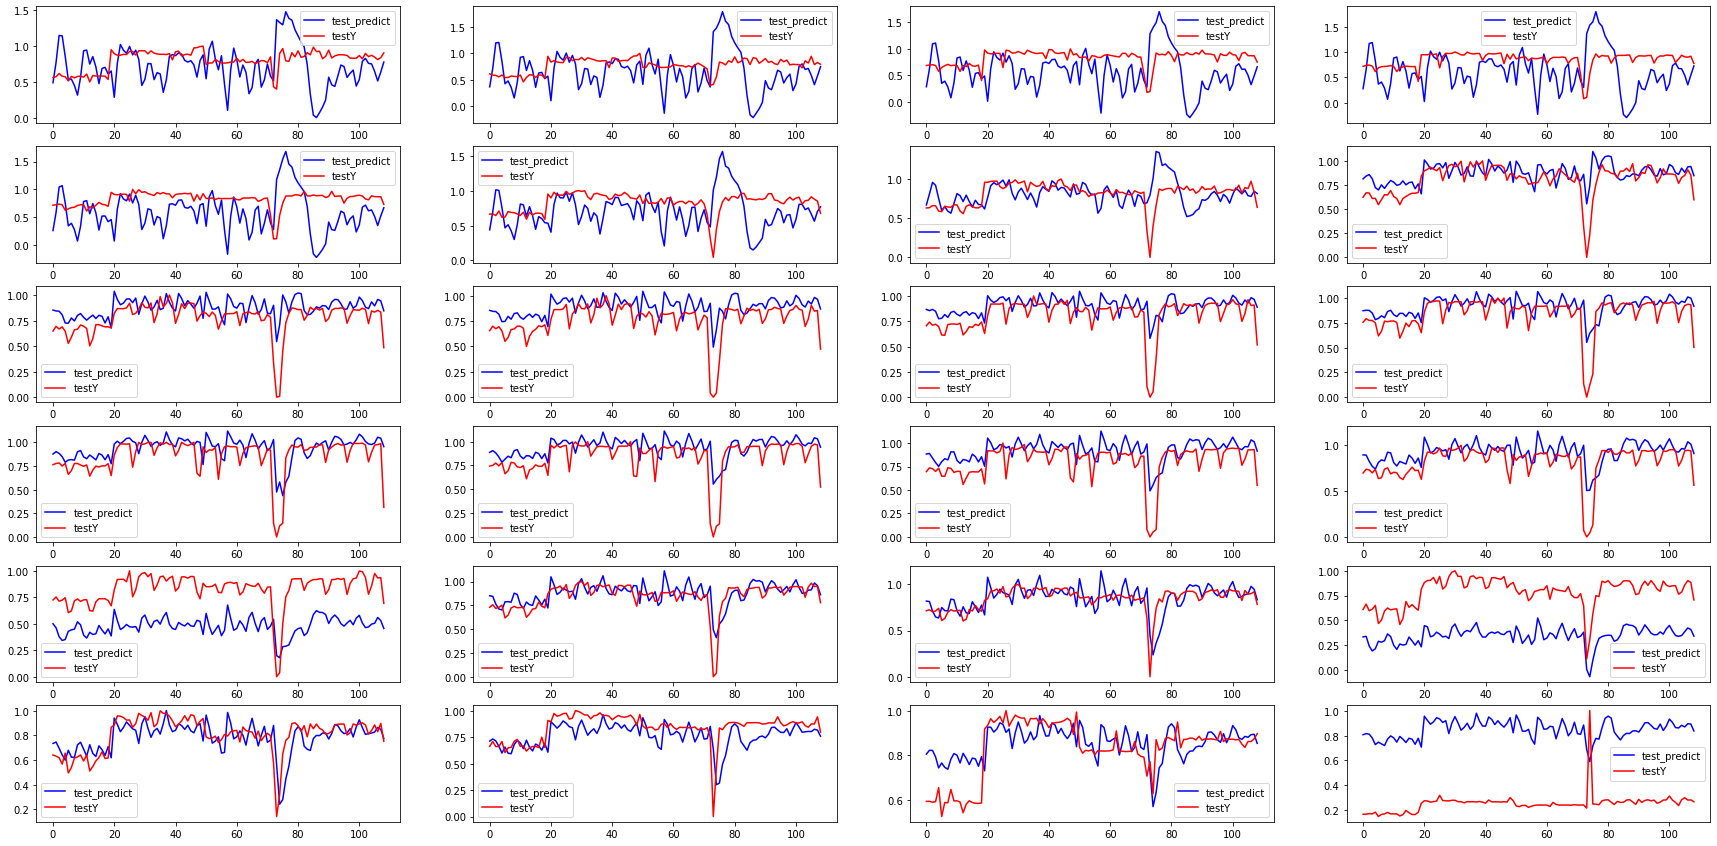

In [65]:
import matplotlib.pyplot as plt
# Plot predictions
plt.figure(figsize=(30, 15))

for i in range(24):
    plt.subplot(6,4,i+1)
    plt.plot(test_predict[:,i], c='blue', label='test_predict')
    plt.plot(testY[:,i], c='red', label='testY')
    plt.legend()
plt.show()